# OsmGt example

## Imports and prepare input parameters

In [1]:
from IPython.display import display

from bokeh.plotting import output_notebook
from bokeh.plotting import show

import geopandas as gpd

from shapely.geometry import Point
from shapely.ops import linemerge

from gdf2bokeh import Gdf2Bokeh

from osmgt import OsmGt

from graph_tool.topology import shortest_path


output_notebook()


location = "Roanne"


Loading BokehJS ...

## Get POIs

In [2]:
%%time

pois_gdf = OsmGt.pois_from_location(location).get_gdf()

display(pois_gdf.head(2))

2021-04-29 09:50:54 - OsmGtPoi        - INFO     : From location: Roanne
2021-04-29 09:50:54 - OsmGtPoi        - INFO     : Loading data...
2021-04-29 09:50:54 - OsmGtPoi        - INFO     : NominatimApi: Query 200:OK in 0.14 sec.
2021-04-29 09:50:55 - OsmGtPoi        - INFO     : OverpassApi: Query 200:OK in 0.7 sec.
2021-04-29 09:50:55 - OsmGtPoi        - INFO     : Formating data
2021-04-29 09:50:55 - OsmGtPoi        - INFO     : Prepare GeoDataframe
2021-04-29 09:50:55 - OsmGtPoi        - INFO     : GeoDataframe Ready


,addr:postcode,amenity,atm,change_machine,name,opening_hours,operator,phone,ref:FR:LaPoste,source,...,service:bicycle:repair,check_date:opening_hours,contact:email,contact:facebook,source:opening_hours,clothes,waste,office,second_hand,geometry
0,42300,post_office,yes,yes,Roanne Principal,"Mo,We-Fr 08:30-18:00; Tu 08:30-12:00,13:45-18:...",La Poste,3631,07916A,data.gouv.fr:LaPoste - 10/2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (4.07225 46.04071)
1,NaN,place_of_worship,NaN,NaN,Chapelle Jean Puy,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (4.07073 46.03766)


CPU times: user 155 ms, sys: 10.5 ms, total: 166 ms
Wall time: 967 ms


## Get Roads

In [3]:
%%time
roads_initialized = OsmGt.roads_from_location(
    location,
    mode="vehicle",
    additional_nodes=pois_gdf
)
roads_gdf = roads_initialized.get_gdf()

display(roads_gdf.head(2))

2021-04-29 09:50:55 - OsmGtRoads      - INFO     : From location: Roanne
2021-04-29 09:50:55 - OsmGtRoads      - INFO     : Loading data...
2021-04-29 09:50:55 - OsmGtRoads      - INFO     : NominatimApi: Query 200:OK in 0.13 sec.
2021-04-29 09:50:56 - OsmGtRoads      - INFO     : OverpassApi: Query 200:OK in 0.88 sec.
2021-04-29 09:50:57 - OsmGtRoads      - INFO     : Rebuild network data
2021-04-29 09:50:57 - OsmGtRoads      - INFO     : Network cleaning...
2021-04-29 09:50:57 - OsmGtRoads      - INFO     : Starting: Adding new nodes on the network
2021-04-29 09:50:57 - OsmGtRoads      - INFO     : Find nearest line for each node
2021-04-29 09:50:57 - OsmGtRoads      - INFO     : Split line
2021-04-29 09:50:57 - OsmGtRoads      - INFO     : Topology lines checker: to add: 267, to split: 264
2021-04-29 09:50:57 - OsmGtRoads      - INFO     : Starting: Find intersections
2021-04-29 09:50:57 - OsmGtRoads      - INFO     : Done: Find intersections
2021-04-29 09:50:57 - OsmGtRoads      - 

,highway,lanes:forward,maxspeed,name,oneway,ref,id,osm_url,topo_uuid,topology,...,sidewalk:bicycle,name:etymology:wikidata,EntityHand,SubClasses,alt_name,turn:lanes,source:name,maxspeed:backward,maxspeed:forward,geometry
0,primary,2,50,Rue de Charlieu,yes,D 482,24035569,https://www.openstreetmap.org/way/24035569,1_forward,unchanged,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (4.08544 46.05234, 4.08546 46.05248..."
1,primary,NaN,50,Rue de Charlieu,yes,D 482,24035570,https://www.openstreetmap.org/way/24035570,2_forward,unchanged,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (4.09087 46.06639, 4.09084 46.06622..."


CPU times: user 1.14 s, sys: 103 ms, total: 1.25 s
Wall time: 2.15 s


## Display roads and nodes

In [4]:
%%time
layers_to_add = [
    {
        "input_gdf": roads_gdf,
        "legend": "roads",
        "color": "black",
    },
    {
        "input_gdf": pois_gdf,
        "legend": "POIs",
        "color": "blue",
        "size": 9
    },
]



my_map = Gdf2Bokeh(
    "My roads and POIs - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
# print(dir(my_map))
# print(my_map._Gdf2Bokeh__BOKEH_LAYER_CONTAINERS)



show(my_map.figure)

CPU times: user 146 ms, sys: 9.23 ms, total: 155 ms
Wall time: 148 ms


## Check topology details

In [5]:
%%time

roads_topology_gdfs = roads_initialized.topology_checker()

lines_unchanged = roads_topology_gdfs["lines_unchanged"]
lines_added = roads_topology_gdfs["lines_added"]
lines_split = roads_topology_gdfs["lines_split"]
nodes_added = roads_topology_gdfs["nodes_added"]
intersections_added = roads_topology_gdfs["intersections_added"]

layers_to_add = [
    {
        "input_gdf": lines_unchanged,
        "legend": "roads unchanged",
        "color": "black",
    },
    {
        "input_gdf": lines_added,
        "legend": "roads added",
        "color": "green",
    },
    {
        "input_gdf": lines_split,
        "legend": "roads split",
        "color": "orange",
    },
    {
        "input_gdf": intersections_added,
        "legend": "Intersections added",
        "color": "brown",
    },
    {
        "input_gdf": nodes_added,
        "legend": "Nodes added",  # POIs here
        "style": "square",
        "color": "blue",
        "size": 9
    },
]

my_map = Gdf2Bokeh(
    "Topology about my roads and POIs - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_map.figure)

2021-04-29 09:50:58 - OsmGtRoads      - INFO     : Prepare topology data
2021-04-29 09:50:58 - OsmGtRoads      - INFO     : GeoDataframe Ready


CPU times: user 3.43 s, sys: 64.5 ms, total: 3.5 s
Wall time: 3.48 s


## Get the graph-tool network and display it

2021-04-29 09:51:01 - OsmGtRoads      - INFO     : Prepare graph
2021-04-29 09:51:02 - OsmGtRoads      - INFO     : Graph to image


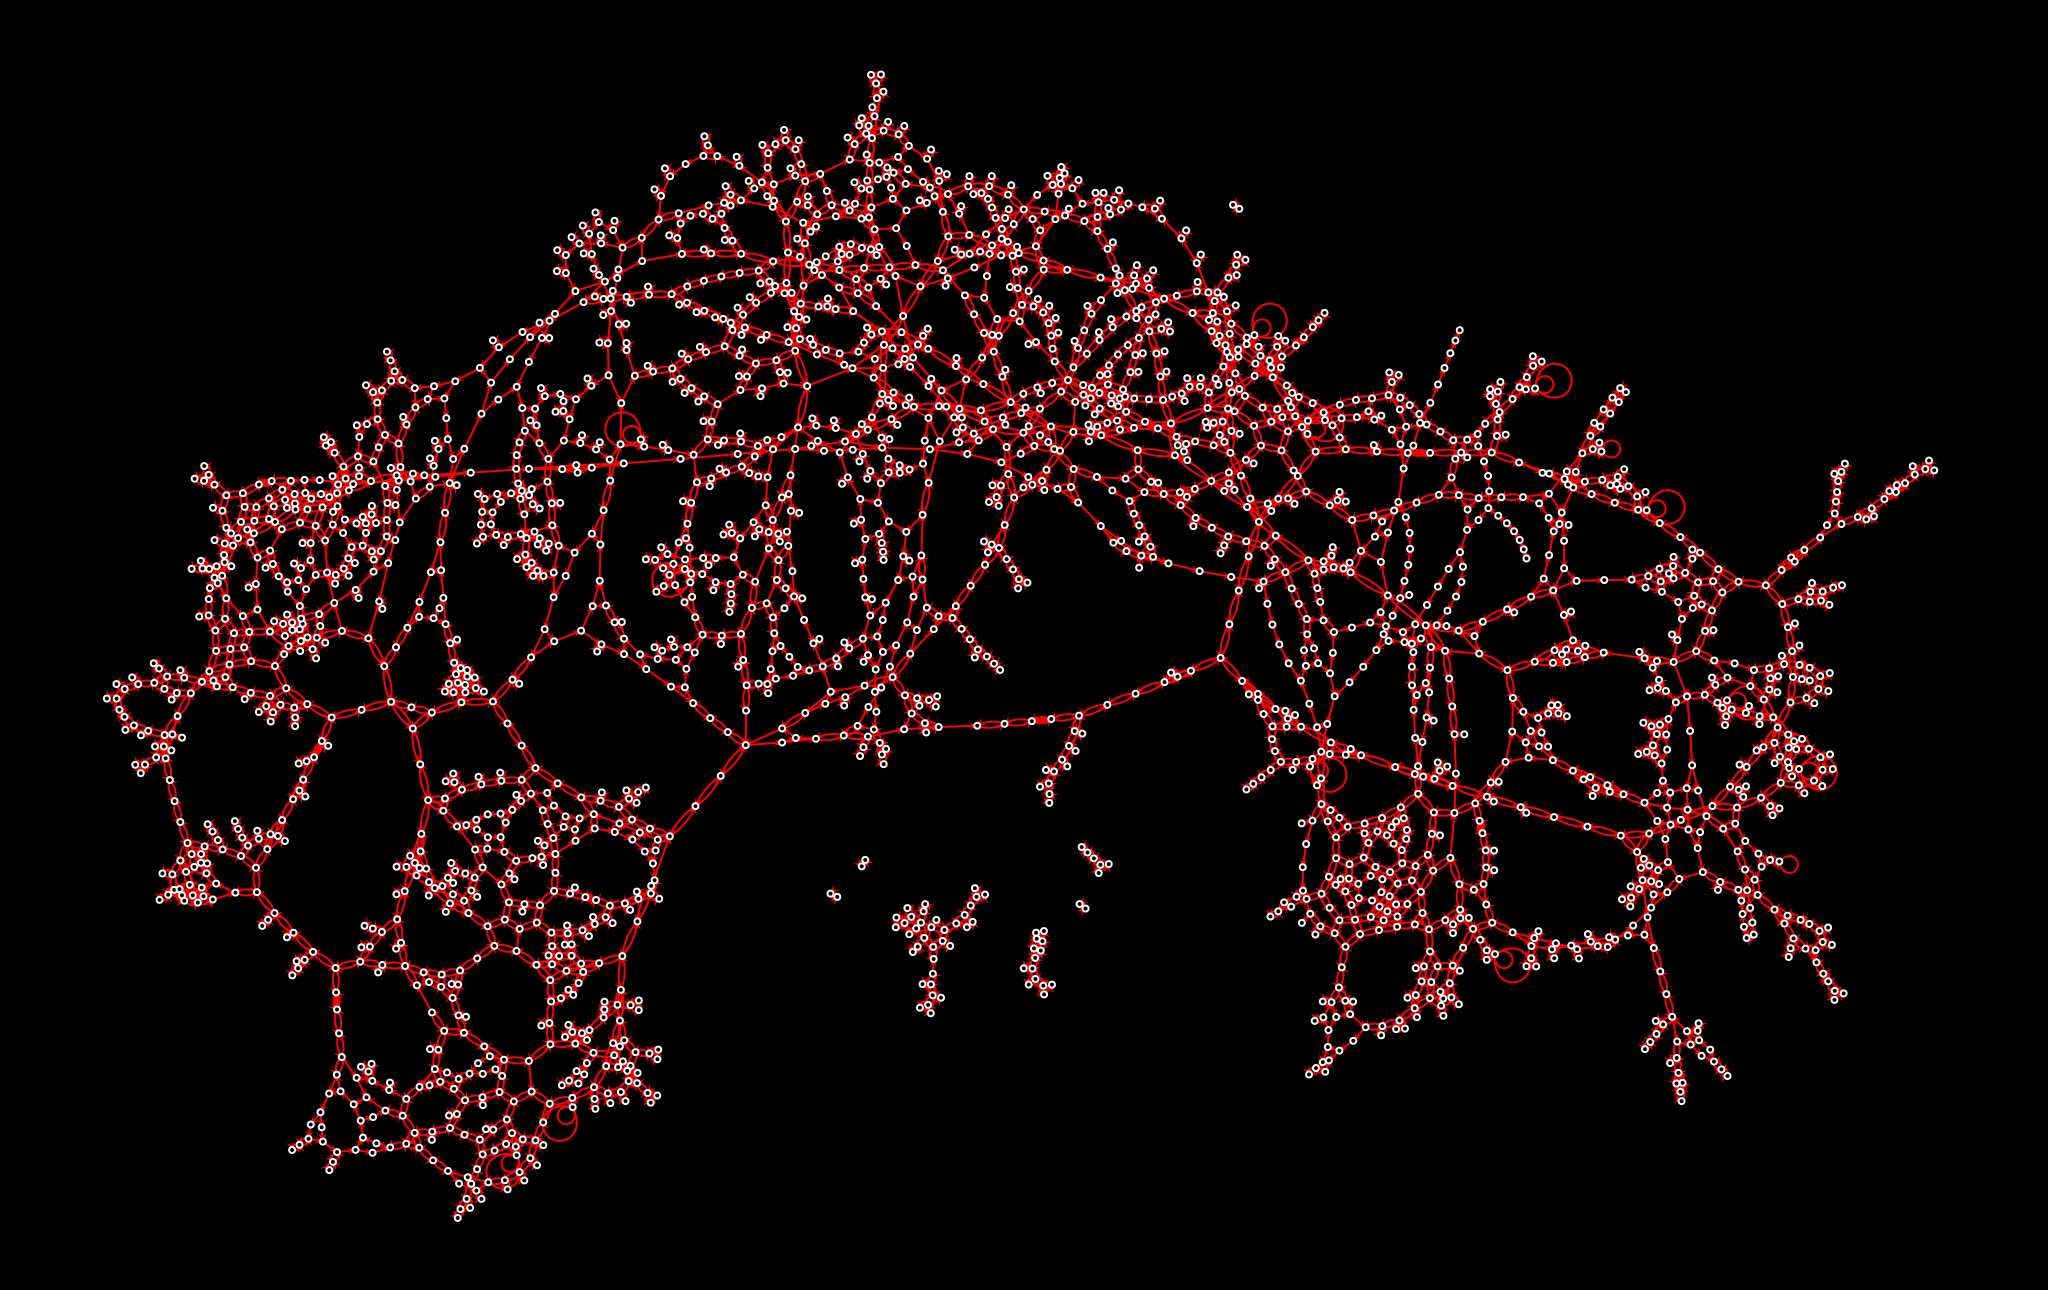

CPU times: user 16.4 s, sys: 93.1 ms, total: 16.5 s
Wall time: 6.61 s


In [6]:
%%time
graph = roads_initialized.get_graph()

# a plot method has been added on OsmGT.
graph.plot()

## Compute a shortest path 

### With graph-tools function

In [7]:
%%time
# now, we have to define a start point and a end point and get their wkt
start_node_topo_uuid = 47
end_node_topo_uuid = 63

# 'topo_uuid' is generated by osmgt (during the topology processing).
# Some roads has been split that's whyso this id has been created.
start_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == end_node_topo_uuid]

start_node_wkt = start_node_gdf.iloc[0]["geometry"].wkt
end_node_wkt = end_node_gdf.iloc[0]["geometry"].wkt

# the graph have some methods (graph-tools method always exists!) to find egdes, vertices... Let's use the .find_vertex_from_name(). the wkt is the vertex name...
source_vertex = graph.find_vertex_from_name(start_node_wkt)
target_vertex = graph.find_vertex_from_name(end_node_wkt)

# shortest path computing...
path_vertices, path_edges = shortest_path(
    graph,
    source=source_vertex,
    target=target_vertex,
    weights=graph.edge_weights  # weigth is based on line length
)

# get path by using edge names
roads_ids = [
    graph.edge_names[edge]
    for edge in path_edges
]

roads_gdf_copy = roads_gdf.copy(deep=True)
shortest_path_found = roads_gdf_copy[roads_gdf['topo_uuid'].isin(roads_ids)].to_crs(3857)['geometry'].to_list()
shortest_path_found_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:3857", geometry=[linemerge(shortest_path_found)])

layers_to_add = [
    {
        "input_gdf": shortest_path_found_gdf,
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "My shortest path - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

CPU times: user 235 ms, sys: 47 ms, total: 282 ms
Wall time: 279 ms


### With OsmGt function

In [8]:
%%time

start_node_topo_uuid = 47
end_node_topo_uuid = 63

start_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == end_node_topo_uuid]

start_node = start_node_gdf.iloc[0]["geometry"]
end_node = end_node_gdf.iloc[0]["geometry"]

shortest_paths = OsmGt.shortest_path_from_location(
    "Roanne",
    [
        (start_node, end_node),
        (start_node, end_node),  # duplicate pairs are cleaned
    ],
    mode="pedestrian"
)
layers_to_add = [
    {
        "input_gdf": shortest_paths[["geometry"]],
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "My shortest path - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

display(shortest_paths)

2021-04-29 09:51:08 - OsmGtShortestPath - INFO     : Shortest path processing...
2021-04-29 09:51:08 - OsmGtShortestPath - INFO     : From location: Roanne
2021-04-29 09:51:08 - OsmGtShortestPath - INFO     : Loading data...
2021-04-29 09:51:08 - OsmGtShortestPath - INFO     : NominatimApi: Query 200:OK in 0.15 sec.
2021-04-29 09:51:11 - OsmGtShortestPath - INFO     : OverpassApi: Query 200:OK in 2.23 sec.
2021-04-29 09:51:11 - OsmGtShortestPath - INFO     : Rebuild network data
2021-04-29 09:51:11 - OsmGtShortestPath - INFO     : Network cleaning...
2021-04-29 09:51:11 - OsmGtShortestPath - INFO     : Starting: Adding new nodes on the network
2021-04-29 09:51:11 - OsmGtShortestPath - INFO     : Find nearest line for each node
2021-04-29 09:51:11 - OsmGtShortestPath - INFO     : Split line
2021-04-29 09:51:11 - OsmGtShortestPath - INFO     : Topology lines checker: to add: 2, to split: 2
2021-04-29 09:51:11 - OsmGtShortestPath - INFO     : Starting: Find intersections
2021-04-29 09:51:

,source_node,target_node,osm_ids,osm_urls,geometry,id
0,POINT (4.09177 46.0579),POINT (4.0789385 46.0331249),"24040315, 24040315, 24040315, 24040315, 240403...","https://www.openstreetmap.org/way/24040315, ht...","LINESTRING (4.09177 46.05790, 4.09176 46.05796...",0


CPU times: user 1.65 s, sys: 70.9 ms, total: 1.72 s
Wall time: 4.17 s


## Compute an isochrone

### Isochrone from times

In [9]:
%%time

topo_uuids_poi = [99, 167, 188]

source_nodes = pois_gdf[pois_gdf['topo_uuid'].isin(topo_uuids_poi)]

# 2 = 2 min ; 5 = 5 min ; 10 = 10 min
isochrones_polygon_values = {
    1: "#d9ef8b",
    5: "#fee08b",
    10: "#f46d43"
}

isochrones_lines_values = {
    1: "#668100",
    5: "#e2a803",
    10: "#962603"
}

trip_speed = 0.5  # km/h

location_points = list(source_nodes["geometry"])
# location_points.extend(location_points)

isochrones_polygons, isochrones_lines = OsmGt.isochrone_times_from_nodes(
    location_points,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian"
)

isochrones_polygons["color"] = isochrones_polygons["iso_name"].map(lambda x: isochrones_polygon_values[x])
isochrones_lines["color"] = isochrones_lines["iso_name"].map(lambda x: isochrones_lines_values[x])


layers_to_add = [
    {
        "input_gdf": source_nodes,
        "legend": "Source nodes",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "Isochrones from times - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

print("\nIsochrones polygons output")
display(isochrones_polygons)

print("\nIsochrones lines output")
display(isochrones_lines.head(2))


2021-04-29 09:51:12 - OsmGtIsochrone  - INFO     : Isochrone processing...
2021-04-29 09:51:12 - OsmGtIsochrone  - INFO     : From bbox: (4.069692239709741, 46.03401699098607, 4.073144960290258, 46.03687298221108)
2021-04-29 09:51:12 - OsmGtIsochrone  - INFO     : Loading data...
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 1.47 sec.
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : Rebuild network data
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : Network cleaning...
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : Split line
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 3, to split: 3
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2021-04-29 09:51:14 - OsmGtIsochrone  - INFO     : Done: Find intersec

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='1895', ...)



Isochrones polygons output


,iso_name,time_unit,iso_distance,distance_unit,geometry,id,color
0,10,minutes,84,meters,"POLYGON ((4.06972 46.03605, 4.06974 46.03615, ...",0,#f46d43
1,10,minutes,84,meters,"POLYGON ((4.07196 46.03422, 4.07195 46.03421, ...",1,#f46d43
2,5,minutes,42,meters,"POLYGON ((4.07043 46.03588, 4.07040 46.03596, ...",2,#fee08b
3,5,minutes,42,meters,"POLYGON ((4.07143 46.03633, 4.07149 46.03636, ...",3,#fee08b
4,5,minutes,42,meters,"POLYGON ((4.07197 46.03440, 4.07197 46.03440, ...",4,#fee08b
5,5,minutes,42,meters,"POLYGON ((4.07224 46.03457, 4.07220 46.03453, ...",5,#fee08b
6,1,minutes,9,meters,"POLYGON ((4.07066 46.03584, 4.07067 46.03586, ...",6,#d9ef8b
7,1,minutes,9,meters,"POLYGON ((4.07185 46.03617, 4.07188 46.03619, ...",7,#d9ef8b
8,1,minutes,9,meters,"POLYGON ((4.07219 46.03468, 4.07221 46.03468, ...",8,#d9ef8b



Isochrones lines output


,cycleway:left,cycleway:right,highway,lanes,maxspeed,name,oneway,oneway:bicycle,surface,zone:maxspeed,...,cycleway,source:maxspeed,cycleway:both,service,access,psv,iso_name,iso_distance,geometry,color
4,NaN,NaN,residential,NaN,NaN,Rue Voltaire,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.0,"LINESTRING (4.07221 46.03462, 4.07223 46.03465)",#668100
5,NaN,NaN,residential,NaN,NaN,Rue Voltaire,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,84.0,"LINESTRING (4.07176 46.03404, 4.07176 46.03404...",#962603


CPU times: user 1.93 s, sys: 705 ms, total: 2.63 s
Wall time: 9.96 s


### Isochrone from distances

In [11]:
%%time

topo_uuids_poi = [99, 167, 188]

source_nodes = pois_gdf[pois_gdf['topo_uuid'].isin(topo_uuids_poi)]

# 2 = 2 min ; 5 = 5 min ; 10 = 10 min
isochrones_polygon_values = {
    20: "#d9ef8b",
    50: "#fee08b",
    100: "#f46d43"
}

isochrones_lines_values = {
    20: "#668100",
    50: "#e2a803",
    100: "#962603"
}

trip_speed = 3  # km/h

location_points = list(source_nodes["geometry"])
# location_points.extend(location_points)

isochrones_polygons, isochrones_lines = OsmGt.isochrone_distances_from_nodes(
    location_points,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian"
)

isochrones_polygons["color"] = isochrones_polygons["iso_distance"].map(lambda x: isochrones_polygon_values[x])
isochrones_lines["color"] = isochrones_lines["iso_distance"].map(lambda x: isochrones_lines_values[x])


layers_to_add = [
    {
        "input_gdf": source_nodes,
        "legend": "Source nodes",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = Gdf2Bokeh(
    "Isochrones from times - from OsmGT (https://github.com/amauryval)",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

print("\nIsochrones polygons output")
display(isochrones_polygons)

print("\nIsochrones lines output")
display(isochrones_lines.head(2))


2021-04-29 09:51:22 - OsmGtIsochrone  - INFO     : Isochrone processing...
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : From bbox: (4.069505390130645, 46.033887274031926, 4.073331809869355, 46.03700269215695)
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Loading data...
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.59 sec.
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Rebuild network data
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Network cleaning...
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Split line
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 3, to split: 3
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2021-04-29 09:51:23 - OsmGtIsochrone  - INFO     : Done: Find interse

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='2131', ...)



Isochrones polygons output


,iso_name,time_unit,iso_distance,distance_unit,geometry,id,color
0,2.0,minutes,100,meters,"POLYGON ((4.07199 46.03570, 4.07195 46.03557, ...",0,#f46d43
1,2.0,minutes,100,meters,"POLYGON ((4.07158 46.03403, 4.07157 46.03403, ...",1,#f46d43
2,1.0,minutes,50,meters,"POLYGON ((4.07014 46.03596, 4.07011 46.03597, ...",2,#fee08b
3,1.0,minutes,50,meters,"POLYGON ((4.07137 46.03633, 4.07145 46.03636, ...",3,#fee08b
4,1.0,minutes,50,meters,"POLYGON ((4.07191 46.03434, 4.07193 46.03436, ...",4,#fee08b
5,1.0,minutes,50,meters,"POLYGON ((4.07200 46.03427, 4.07200 46.03427, ...",5,#fee08b
6,1.0,minutes,50,meters,"POLYGON ((4.07230 46.03465, 4.07229 46.03472, ...",6,#fee08b
7,0.4,minutes,20,meters,"POLYGON ((4.07065 46.03586, 4.07068 46.03592, ...",7,#d9ef8b
8,0.4,minutes,20,meters,"POLYGON ((4.07177 46.03625, 4.07182 46.03624, ...",8,#d9ef8b
9,0.4,minutes,20,meters,"POLYGON ((4.07216 46.03465, 4.07219 46.03469, ...",9,#d9ef8b



Isochrones lines output


,cycleway:left,cycleway:right,highway,lanes,maxspeed,name,oneway,oneway:bicycle,surface,zone:maxspeed,...,cycleway,source:maxspeed,cycleway:both,service,access,psv,iso_name,iso_distance,geometry,color
0,NaN,NaN,residential,NaN,30,Rue Alphonse Coste,yes,no,NaN,FR:30,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,100.0,"LINESTRING (4.07244 46.03629, 4.07250 46.03631...",#962603
2,NaN,NaN,unclassified,NaN,NaN,Rue de la Berge,NaN,NaN,NaN,NaN,...,lane,NaN,NaN,NaN,NaN,NaN,2.0,100.0,"LINESTRING (4.07176 46.03404, 4.07176 46.03403...",#962603


CPU times: user 1.32 s, sys: 60.8 ms, total: 1.38 s
Wall time: 2.91 s
